In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from datetime import timedelta
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

In [ ]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
hist_txns_cols = ['card_id','month_lag','purchase_date','authorized_flag','installments','purchase_amount','merchant_id']
hist_txns = pd.read_csv('data/historical_transactions.csv',usecols=hist_txns_cols)
merchant = pd.read_csv('data/merchants.csv')
merchant_txns_cols = ['card_id','month_lag','purchase_date','authorized_flag','installments','purchase_amount','merchant_id']
merchant_txns = pd.read_csv('data/new_merchant_transactions.csv',usecols=merchant_txns_cols)

In [ ]:
# convertitng to str
hist_txns['installments'] = hist_txns['installments'].astype(str).replace('-1','0').replace('999','0')
merchant_txns['installments'] = merchant_txns['installments'].astype(str).replace('-1','0').replace('999','0')

In [ ]:
mer = merchant
le = LabelEncoder()
mer['merchant_group_id'] = le.fit_transform(merchant['merchant_group_id'])
le = LabelEncoder()
mer['merchant_category_id'] = le.fit_transform(merchant['merchant_category_id'])
le = LabelEncoder()
mer['subsector_id'] = le.fit_transform(merchant['subsector_id'])
le = LabelEncoder()
mer['category_1'] = le.fit_transform(merchant['category_1'])
le = LabelEncoder()
mer['most_recent_sales_range'] = le.fit_transform(merchant['most_recent_sales_range'])
le = LabelEncoder()
mer['most_recent_purchases_range'] = le.fit_transform(merchant['most_recent_purchases_range'])
le = LabelEncoder()
mer['category_4'] = le.fit_transform(merchant['category_4'])
le = LabelEncoder()
mer['city_id'] = le.fit_transform(merchant['city_id'])
le = LabelEncoder()
mer['state_id'] = le.fit_transform(merchant['state_id'])
le = LabelEncoder()
mer['category_2'] = le.fit_transform(merchant['category_2'])
mer = mer.fillna(0)
mer = mer.replace(np.inf, 0)
mer_x =  mer.drop(columns = 'merchant_id')

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(mer_x)
kmeans.labels_.shape

In [ ]:
mer_cluster = pd.DataFrame(columns=['merchant_id', 'merchant_cluster'])
mer_cluster['merchant_id'] = merchant['merchant_id']
mer_cluster['merchant_cluster'] = kmeans.labels_.tolist()
mer_cluster['merchant_cluster'] = mer_cluster['merchant_cluster'].astype(str).apply(lambda x: x.split('.')[0])

In [ ]:
del merchant
del mer
del mer_x
del le 

In [ ]:
merchant_txns = merchant_txns.merge(mer_cluster,how='left',on='merchant_id')
hist_txns = hist_txns.merge(mer_cluster,how='left',on='merchant_id')
hist_txns.drop(columns=['merchant_id','month_lag'],inplace=True)
merchant_txns.drop(columns=['merchant_id','month_lag'],inplace=True)

In [ ]:
merchant_txns['merchant_cluster']=merchant_txns['merchant_cluster'].fillna('6')

In [ ]:
merchant_txns = pd.DataFrame(merchant_txns.groupby('card_id').apply(np.array).reset_index())
merchant_txns.rename(columns={0: "merchant_grouped"},inplace=True)

In [ ]:
hist_txns = pd.DataFrame(hist_txns.groupby('card_id').apply(np.array).reset_index())
hist_txns.rename(columns={0: "hist_grouped"},inplace=True)

In [ ]:
train_df['first_year'] = train_df['first_active_month'].astype(str).apply(lambda x: x.split('-')[0])
train_df['first_month'] = train_df['first_active_month'].astype(str).apply(lambda x: x.split('-')[1])
test_df.loc[test_df['first_active_month'].isnull(),'first_active_month']='2017-12'
test_df['first_year'] = test_df['first_active_month'].astype(str).apply(lambda x: x.split('-')[0])
test_df['first_month'] = test_df['first_active_month'].astype(str).apply(lambda x: x.split('-')[1])
train_df.drop(columns='first_active_month',inplace=True)
test_df.drop(columns='first_active_month',inplace=True)

In [ ]:
train_df = train_df.merge(hist_txns,how='left',on='card_id')
train_df = train_df.merge(merchant_txns,how='left',on='card_id')
join_train_df = train_df.merge(merchant_txns,how='inner',on='card_id')

In [ ]:
test_df = test_df.merge(hist_txns,how='left',on='card_id')
test_df = test_df.merge(merchant_txns,how='left',on='card_id')
join_test_df = test_df.merge(merchant_txns,how='inner',on='card_id')

In [ ]:
del hist_txns
del merchant_txns

In [ ]:
txn_header = ['authorized_flag', 'card_id', 'installments', 'purchase_amount','purchase_date','merchant_cluster']

In [ ]:
def make_pd_transactions_dataframe(rows, header):
    return pd.DataFrame({header[i]: [row[i] for row in rows] for i in range(len(header))})

def get_pandas_transactions_dataframe(transaction_rows):
    transaction_df = make_pd_transactions_dataframe(transaction_rows, txn_header)
    transaction_df['purchase_date'] = pd.to_datetime(transaction_df['purchase_date'].apply(lambda x:x.split(' ')[0]), format="%Y-%m-%d") 
    return transaction_df

def filter_by_date(alert_date, transaction_df, filter_value):
    end_date = alert_date - timedelta(filter_value)
    data = transaction_df[(transaction_df['purchase_date'] <= alert_date) & (transaction_df['purchase_date'] > end_date)]
    return data
def filter_by_flag(transaction_df, filter_value):
    return transaction_df[transaction_df['authorized_flag']==filter_value]

def filter_by_install(transaction_df, filter_value):
    return transaction_df[transaction_df['installments'].isin(filter_value)]

def filter_by_cluster(transaction_df, filter_value):
    return transaction_df[transaction_df['merchant_cluster']==filter_value]

In [ ]:
def compute(grouped_rows,date=None, filter=None, filter_value=None):
    df = get_pandas_transactions_dataframe(grouped_rows)
    if df is not None:
        if filter == 'date':
            filter_df = filter_by_date(date,df, filter_value)
        if filter == 'flag':
            filter_df = filter_by_flag(df, filter_value)
        if filter == 'install':
            filter_df = filter_by_install(df, filter_value)
        if filter =='cluster':
            filter_df = filter_by_cluster(df, filter_value)
        if len(filter_df) == 0:
            sum_out = 0
            avg_out = 0
            count_out = 0
        else:
            sum_out = filter_df['purchase_amount'].sum()
            avg_out = filter_df['purchase_amount'].mean()
            count_out = len(filter_df)
        return sum_out, avg_out, count_out
    else: return 0,0,0

In [ ]:
hist_date = pd.to_datetime('2018-02-28', format="%Y-%m-%d")
merch_date = pd.to_datetime('2018-04-30', format="%Y-%m-%d")

In [ ]:
train_df['30day_sum'], train_df['30day_avg'], train_df['30day_count']= zip(*train_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=30), axis=1))
train_df['60day_sum'], train_df['60day_avg'], train_df['60day_count']= zip(*train_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=60), axis=1))
train_df['90day_sum'], train_df['90day_avg'], train_df['90day_count']= zip(*train_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=90), axis=1))
train_df['180day_sum'], train_df['180day_avg'], train_df['180day_count']= zip(*train_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=180), axis=1))
train_df['>360day_sum'], train_df['>360day_avg'], train_df['>360day_count']= zip(*train_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=500), axis=1))
train_df['authY_sum'],train_df['authY_avg'],train_df['authY_count'] = zip(*train_df.apply(lambda x: compute(x['merchant_grouped'], filter='flag', filter_value='Y'), axis=1))
train_df['authN_sum'],train_df['authN_avg'],train_df['authN_count'] = zip(*train_df.apply(lambda x: compute(x['merchant_grouped'], filter='flag', filter_value='N'), axis=1))
train_df['zero_install_sum'],train_df['zero_install_avg'],train_df['zero_install_count'] = zip(*train_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['0']), axis=1))
train_df['low_intall_sum'],train_df['low_intall_avg'],train_df['low_intall_count'] = zip(*train_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['1','2','3']), axis=1))
train_df['med_intall_sum'],train_df['med_intall_avg'],train_df['med_intall_count'] = zip(*train_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['4','5','6']), axis=1))
train_df['high_intall_sum'],train_df['high_intall_avg'],train_df['high_intall_count'] = zip(*train_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['7','8','9']), axis=1))
train_df['vhigh_intall_sum'],train_df['vhigh_intall_avg'],train_df['vhigh_intall_count'] = zip(*train_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['10','11','12']), axis=1))
train_df['cluster0_sum'],train_df['cluster0_avg'],train_df['cluster0_count'] = zip(*train_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='0'), axis=1))
train_df['cluster1_sum'],train_df['cluster1_avg'],train_df['cluster1_count'] = zip(*train_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='1'), axis=1))
train_df['cluster2_sum'],train_df['cluster2_avg'],train_df['cluster2_count'] = zip(*train_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='2'), axis=1))
train_df['cluster3_sum'],train_df['cluster3_avg'],train_df['cluster3_count'] = zip(*train_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='3'), axis=1))
train_df['cluster4_sum'],train_df['cluster4_avg'],train_df['cluster4_count'] = zip(*train_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='4'), axis=1))

In [ ]:
test_df['30day_sum'], test_df['30day_avg'], test_df['30day_count']= zip(*test_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=30), axis=1))
test_df['60day_sum'], test_df['60day_avg'], test_df['60day_count']= zip(*test_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=60), axis=1))
test_df['90day_sum'], test_df['90day_avg'], test_df['90day_count']= zip(*test_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=90), axis=1))
test_df['180day_sum'], test_df['180day_avg'], test_df['180day_count']= zip(*test_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=180), axis=1))
test_df['>360day_sum'], test_df['>360day_avg'], test_df['>360day_count']= zip(*test_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=500), axis=1))
test_df['authY_sum'],test_df['authY_avg'],test_df['authY_count'] = zip(*test_df.apply(lambda x: compute(x['merchant_grouped'], filter='flag', filter_value='Y'), axis=1))
test_df['authN_sum'],test_df['authN_avg'],test_df['authN_count'] = zip(*test_df.apply(lambda x: compute(x['merchant_grouped'], filter='flag', filter_value='N'), axis=1))
test_df['zero_install_sum'],test_df['zero_install_avg'],test_df['zero_install_count'] = zip(*test_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['0']), axis=1))
test_df['low_intall_sum'],test_df['low_intall_avg'],test_df['low_intall_count'] = zip(*test_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['1','2','3']), axis=1))
test_df['med_intall_sum'],test_df['med_intall_avg'],test_df['med_intall_count'] = zip(*test_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['4','5','6']), axis=1))
test_df['high_intall_sum'],test_df['high_intall_avg'],test_df['high_intall_count'] = zip(*test_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['7','8','9']), axis=1))
test_df['vhigh_intall_sum'],test_df['vhigh_intall_avg'],test_df['vhigh_intall_count'] = zip(*test_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['10','11','12']), axis=1))
test_df['cluster0_sum'],test_df['cluster0_avg'],test_df['cluster0_count'] = zip(*test_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='0'), axis=1))
test_df['cluster1_sum'],test_df['cluster1_avg'],test_df['cluster1_count'] = zip(*test_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='1'), axis=1))
test_df['cluster2_sum'],test_df['cluster2_avg'],test_df['cluster2_count'] = zip(*test_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='2'), axis=1))
test_df['cluster3_sum'],test_df['cluster3_avg'],test_df['cluster3_count'] = zip(*test_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='3'), axis=1))
test_df['cluster4_sum'],test_df['cluster4_avg'],test_df['cluster4_count'] = zip(*test_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='4'), axis=1))

In [ ]:
join_train_df['m_30day_sum'], join_train_df['m_30day_avg'], join_train_df['m_30day_count']= zip(*join_train_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=30), axis=1))
join_train_df['m_60day_sum'], join_train_df['m_60day_avg'], join_train_df['m_60day_count']= zip(*join_train_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=60), axis=1))
join_train_df['m_90day_sum'], join_train_df['m_90day_avg'], join_train_df['m_90day_count']= zip(*join_train_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=90), axis=1))
join_train_df['m_180day_sum'], join_train_df['m_180day_avg'], join_train_df['m_180day_count']= zip(*join_train_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=180), axis=1))
join_train_df['m_>360day_sum'], join_train_df['m_>360day_avg'], join_train_df['m_>360day_count']= zip(*join_train_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=500), axis=1))
join_train_df['m_authY_sum'],join_train_df['m_authY_avg'],join_train_df['m_authY_count'] = zip(*join_train_df.apply(lambda x: compute(x['merchant_grouped'], filter='flag', filter_value='Y'), axis=1))
join_train_df['m_authN_sum'],join_train_df['m_authN_avg'],join_train_df['m_authN_count'] = zip(*join_train_df.apply(lambda x: compute(x['merchant_grouped'], filter='flag', filter_value='N'), axis=1))
join_train_df['m_zero_install_sum'],join_train_df['m_zero_install_avg'],join_train_df['m_zero_install_count'] = zip(*join_train_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['0']), axis=1))
join_train_df['m_low_intall_sum'],join_train_df['m_low_intall_avg'],join_train_df['m_low_intall_count'] = zip(*join_train_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['1','2','3']), axis=1))
join_train_df['m_med_intall_sum'],join_train_df['m_med_intall_avg'],join_train_df['m_med_intall_count'] = zip(*join_train_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['4','5','6']), axis=1))
join_train_df['m_high_intall_sum'],join_train_df['m_high_intall_avg'],join_train_df['m_high_intall_count'] = zip(*join_train_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['7','8','9']), axis=1))
join_train_df['m_vhigh_intall_sum'],join_train_df['m_vhigh_intall_avg'],join_train_df['m_vhigh_intall_count'] = zip(*join_train_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['10','11','12']), axis=1))
join_train_df['m_cluster0_sum'],join_train_df['m_cluster0_avg'],join_train_df['m_cluster0_count'] = zip(*join_train_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='0'), axis=1))
join_train_df['m_cluster1_sum'],join_train_df['m_cluster1_avg'],join_train_df['m_cluster1_count'] = zip(*join_train_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='1'), axis=1))
join_train_df['m_cluster2_sum'],join_train_df['m_cluster2_avg'],join_train_df['m_cluster2_count'] = zip(*join_train_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='2'), axis=1))
join_train_df['m_cluster3_sum'],join_train_df['m_cluster3_avg'],join_train_df['m_cluster3_count'] = zip(*join_train_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='3'), axis=1))
join_train_df['m_cluster4_sum'],join_train_df['m_cluster4_avg'],join_train_df['m_cluster4_count'] = zip(*join_train_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='4'), axis=1))

In [ ]:
join_test_df['m_30day_sum'], join_test_df['m_30day_avg'], join_test_df['m_30day_count']= zip(*join_test_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=30), axis=1))
join_test_df['m_60day_sum'], join_test_df['m_60day_avg'], join_test_df['m_60day_count']= zip(*join_test_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=60), axis=1))
join_test_df['m_90day_sum'], join_test_df['m_90day_avg'], join_test_df['m_90day_count']= zip(*join_test_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=90), axis=1))
join_test_df['m_180day_sum'], join_test_df['m_180day_avg'], join_test_df['m_180day_count']= zip(*join_test_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=180), axis=1))
join_test_df['m_>360day_sum'], join_test_df['m_>360day_avg'], join_test_df['m_>360day_count']= zip(*join_test_df.apply(lambda x: compute(x['merchant_grouped'],date= merch_date, filter='date',
                                                     filter_value=500), axis=1))
join_test_df['m_authY_sum'],join_test_df['m_authY_avg'],join_test_df['m_authY_count'] = zip(*join_test_df.apply(lambda x: compute(x['merchant_grouped'], filter='flag', filter_value='Y'), axis=1))
join_test_df['m_authN_sum'],join_test_df['m_authN_avg'],join_test_df['m_authN_count'] = zip(*join_test_df.apply(lambda x: compute(x['merchant_grouped'], filter='flag', filter_value='N'), axis=1))
join_test_df['m_zero_install_sum'],join_test_df['m_zero_install_avg'],join_test_df['m_zero_install_count'] = zip(*join_test_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['0']), axis=1))
join_test_df['m_low_intall_sum'],join_test_df['m_low_intall_avg'],join_test_df['m_low_intall_count'] = zip(*join_test_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['1','2','3']), axis=1))
join_test_df['m_med_intall_sum'],join_test_df['m_med_intall_avg'],join_test_df['m_med_intall_count'] = zip(*join_test_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['4','5','6']), axis=1))
join_test_df['m_high_intall_sum'],join_test_df['m_high_intall_avg'],join_test_df['m_high_intall_count'] = zip(*join_test_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['7','8','9']), axis=1))
join_test_df['m_vhigh_intall_sum'],join_test_df['m_vhigh_intall_avg'],join_test_df['m_vhigh_intall_count'] = zip(*join_test_df.apply(lambda x: compute(x['merchant_grouped'], filter='install', filter_value=['10','11','12']), axis=1))
join_test_df['m_cluster0_sum'],join_test_df['m_cluster0_avg'],join_test_df['m_cluster0_count'] = zip(*join_test_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='0'), axis=1))
join_test_df['m_cluster1_sum'],join_test_df['m_cluster1_avg'],join_test_df['m_cluster1_count'] = zip(*join_test_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='1'), axis=1))
join_test_df['m_cluster2_sum'],join_test_df['m_cluster2_avg'],join_test_df['m_cluster2_count'] = zip(*join_test_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='2'), axis=1))
join_test_df['m_cluster3_sum'],join_test_df['m_cluster3_avg'],join_test_df['m_cluster3_count'] = zip(*join_test_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='3'), axis=1))
join_test_df['m_cluster4_sum'],join_test_df['m_cluster4_avg'],join_test_df['m_cluster4_count'] = zip(*join_test_df.apply(lambda x: compute(x['merchant_grouped'], filter='cluster', filter_value='4'), axis=1))

In [ ]:
join_train_df.drop(columns=['feature_1', 'feature_2', 'feature_3', 'first_year',
       'first_month'],inplace=True)
join_test_df.drop(columns=['feature_1', 'feature_2', 'feature_3', 'first_year',
       'first_month'],inplace=True)

In [ ]:
train_df = train_df.merge(join_train_df,how='left',on='card_id')
test_df = test_df.merge(join_test_df,how='left',on='card_id')

In [5]:
# train_df.to_csv('final_train.csv',index=False)
# test_df.to_csv('final_test.csv',index=False)
train_df = pd.read_csv('final_train.csv')
test_df = pd.read_csv('final_test.csv')

In [6]:
cols_to_use = [col for col in train_df.columns if col not in ['card_id','target']]
print (len(cols_to_use))

107


In [7]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 50,
        "min_child_weight" : 75,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [8]:
train_X = train_df[cols_to_use]
test_X = test_df[cols_to_use]
train_y = train_df['target'].values

pred_test = 0
kf = model_selection.KFold(n_splits=5, random_state=2018, shuffle=True)
for dev_index, val_index in kf.split(train_df):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_test_tmp, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test += pred_test_tmp
pred_test /= 5.

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.73696
[200]	valid_0's rmse: 3.7369
Early stopping, best iteration is:
[181]	valid_0's rmse: 3.73634
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.67757
[200]	valid_0's rmse: 3.68034
Early stopping, best iteration is:
[102]	valid_0's rmse: 3.67737
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.71306
[200]	valid_0's rmse: 3.71277
Early stopping, best iteration is:
[132]	valid_0's rmse: 3.71135
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.70651
[200]	valid_0's rmse: 3.70456
Early stopping, best iteration is:
[185]	valid_0's rmse: 3.70425
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.77026
[200]	valid_0's rmse: 3.77206
Early stopping, best iteration is:
[129]	valid_0's rmse: 3.76937


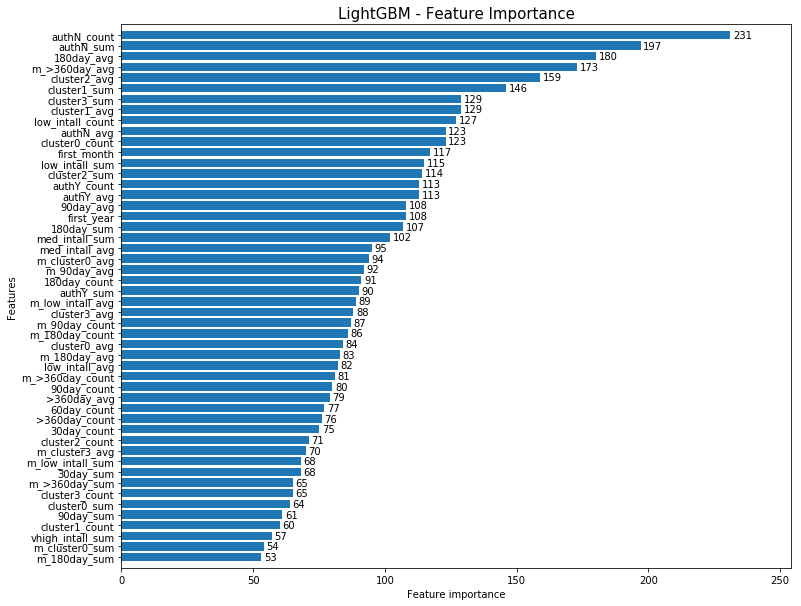

In [9]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [11]:
sub_df = pd.DataFrame({"card_id":train_df["card_id"].values})
sub_df["target"] = pred_test
sub_df.to_csv("baseline_lgb.csv", index=False)